<a href="https://colab.research.google.com/github/wbandabarragan/EPIC_4/blob/main/Day_1/tutorial1_intro_cfd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Advection using Fast Fourier Transform (FFT) Methods

In fluid dynamics, **advection** is the transport of a quantity by bulk motion. The properties are carried with the fluid and are conserved properties.

## Two-way wave equation:

We can study advection using the two-way wave equation, which is a hyperbolic partial differential equation:

$$\frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

where $c$ represents the speed of the propagation of wave.

## One-way wave equation

The above equation can be re-written as two separate one-way wave equations:

$$\frac{\partial u}{\partial t}+c\,\frac{\partial u}{\partial x}=0$$

$$\frac{\partial u}{\partial t}-c\,\frac{\partial u}{\partial x}=0$$

In the first one, an initial perturbation $u(0,x)$ will propagate to the right $u(t, x) = u(0, x − c\,t)$ in time with speed $c$; in the second it will move to the left.

We can integrate this equation in the Fourier transform domain, or in the spatial domain, simply using the FFT to compute derivatives and then transform back.

## The FFT method:

The FFT method is efficient for solving periodic advection problems. It takes advantage of the periodic boundary conditions and the spectral representation of the solution.

Let us Fourier transform the solution from the spatial domainn to the spatial frequency (wavenumber) domain:

$$u(x,t)\rightarrow \hat{u}\,(k,t)$$

$$u\,(x,t) = \int_{-\infty}^{\infty} u(k,t)\ e^{i\,k\,x}\,dk$$

Now, the derivatives:

$$u_x \rightarrow i\,k\,\hat{u}$$

$$u_{xx} \rightarrow -k^2\,\hat{u}$$

Note that the LHS is a vector of data, while the RHS is a vector of Fourier coefficients. Similarly, $k$ represents a vector of spatial frequencies.

The first derivative transports the frequencies, the second derivative difusses frecuencies.

Then, the PDE:

$$\frac{\partial u}{\partial t}+c\,\frac{\partial u}{\partial x}=0$$

$$u_t=-c\,u_x$$


We obtain:

$$\hat{u}_t=-c\,i\,k\,\hat{u}$$

Since the LHS is a function of $k$ and $t$, for every single $k$, we have a separate ODE, which we can solve with any ODE solver numerically.

We have converted our PDE into n decoupled ODEs, one for each $k$.

### Section A: 1D Wave propagation

First we want to study the propagation of a density $\rho$ perturbation from left to right using the FFT method.

$$\frac{\partial \rho}{\partial t} + c\frac{\partial \rho}{\partial x} =0$$

We will consider that the speed of an initial Gaussian density perturbation:

$$\rho(x, 0) = 5\,e^{-x^2/6}$$

propagating across a periodic 1D domain is constant

### Steps:
1. Create an appropriate domain and a reasonable time vector for the problem, and make a plot of the initial density profile.


2. Find the solution, $\rho(x,t)$, **using the FFT method.** Hint: For this we need to write a python function for the right-hand-side (RHS) of the PDE that allows you to map in and out of the Fourier domain at each time.


3. Feed a scipy ODE integrator with the function you created in the previous step. Hint: we need to make sure we feed the correct wavenumbers to the ODE integrator.


In [1]:
# Importing modules

import numpy as np
import matplotlib.pyplot as plt

## Step 1: Domain and IC

### Create the domain:

In [2]:
# Wave speed
c = 1.

# Length of domain
l = 40.

# Number of points
n = 100

# Step size for the domain
delta_x = l/n

# Domain: x-axis vector
x = np.arange(-l/2, +l/2, delta_x)

#print(x.shape)

## 2. Initial profile:

Let's define a hyperbolic secant, which is a proxy for a Gaussian, which should be in the middle of the domain.

In [3]:
# Initial condition

rho_0 = 5*np.exp(-x**2/6)

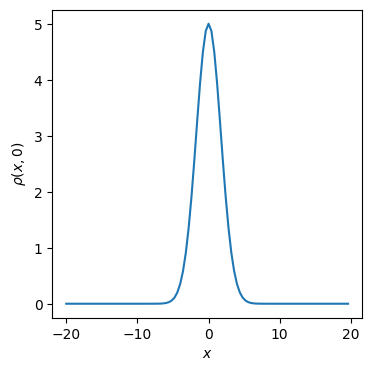

In [4]:
# Plotting

plt.figure(figsize=(4,4))

plt.plot(x, rho_0)

plt.xlabel(r"$x$")
plt.ylabel(r"$\rho(x,0)$")

plt.show()

## Step 2: The FFT method

### Define the spatial frequencies ($k$):

In [5]:
# Wavenumbers -> spatial frequencies:

k_numbers = 2*np.pi*np.fft.fftfreq(len(x), d=delta_x)

#print(k_numbers.shape)
#print(k_numbers)

### FFT of the initial profile:

In [6]:
# FFT of the initial condition

rho_0_hat = np.fft.fft(rho_0)

#print(rho_0_hat.shape)

In [7]:
# Norm of Fourier transform

ampli_rho_0_hat = np.abs(rho_0_hat)/(rho_0_hat.size//2)

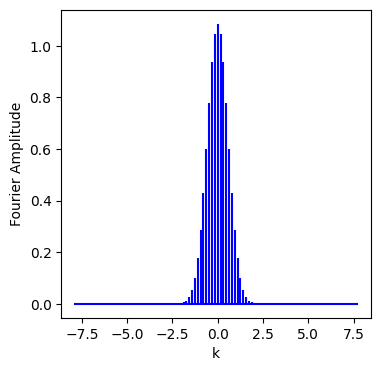

In [8]:
# Plotting

plt.figure(figsize = (4, 4))
plt.stem(k_numbers, ampli_rho_0_hat, 'b', markerfmt=" ", basefmt="-b")
plt.xlabel('k')
plt.ylabel('Fourier Amplitude')

plt.show()

### Concatenate real and complex arrays

ODE integrators don't like complex numbers.

In [9]:
rho_0_conc = np.concatenate((rho_0_hat.real, rho_0_hat.imag))
#print(rho_0_hat.shape, rho_0_conc.shape)

In [10]:
#print(rho_0_conc)

### Time discretisation:

In [11]:
# Time step
t_step = 0.005

# Nnumber of the step in the simulation
m = 500

# Create a time vector
t = np.arange(0, m*t_step, t_step)

#print(t.shape)

### IMPORTANT: Construct ODE (RHS of ODE)

In [12]:
# Function to get RHS

def rhs_ode(rho_0_conc, t, k_numbers, c):
    """
    This is a function that allows us to map the IC into Fourier domain and obtain the resulting ODEs.

    Inputs:
    rho_0_conc -> IC
    t -> time vector
    k_numbers -> wave numbers
    c -> wave speed

    Output:
    rhs_ode -> RHS ODE
    """
    # Needed for the scipy integrator
    u_tilde = rho_0_conc[:n] + (1j)*rho_0_conc[n:]

    # RHS of the equation in Fourier space
    rhs_u_tilde = -(1j)*(c)*(k_numbers)*u_tilde

    # Return real numbers
    rhs_ode = np.concatenate((rhs_u_tilde.real, rhs_u_tilde.imag))

    return rhs_ode

### n ODEs in k: solution in Fourier space

In [13]:
import scipy.integrate as sint

In [14]:

# Call ODE integrator

fourier_sln = sint.odeint(rhs_ode, rho_0_conc, t, args = (k_numbers, c))

#print(fourier_sln.shape)

### Reconstruct Complex solution:

In [15]:
rho_fourier = fourier_sln[:, :n] + (1j)*fourier_sln[:, n:]

#print(rho_fourier.shape)

### Inverse Fourier transform to return to Real space

In [16]:
# For loop with k as index

inv_rho_solution = np.zeros(rho_fourier.shape, dtype = complex)

# Loop to fill up the real sln array
for k in range(len(t)):

    inv_rho_solution[k, :] = np.fft.ifft(rho_fourier[k, :])

#print(inv_rho_solution)

### Plotting the solution:

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


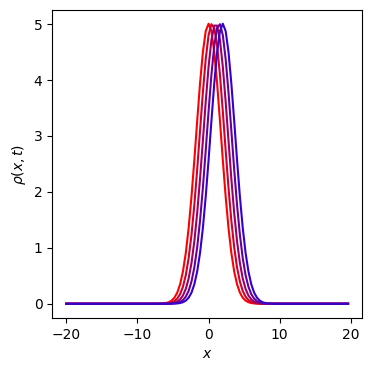

In [17]:
# Add colour to time: Red indicates early times, Blue late times

R = np.linspace(1, 0, m)
G = 0
B = np.linspace(0, 1, m)

# Figure environment
plt.figure(figsize= (4, 4))

for j in range(0, m, 100):
    plt.plot(x, inv_rho_solution[j, :], color = [R[j], G, B[j]])

plt.xlabel(r"$x$")
plt.ylabel(r"$\rho(x,t)$")

plt.show()

### Surface plot:

In [18]:
from mpl_toolkits.mplot3d import axes3d

In [19]:
# Get Meshgrid
x_grid, t_grid = np.meshgrid(x, t)

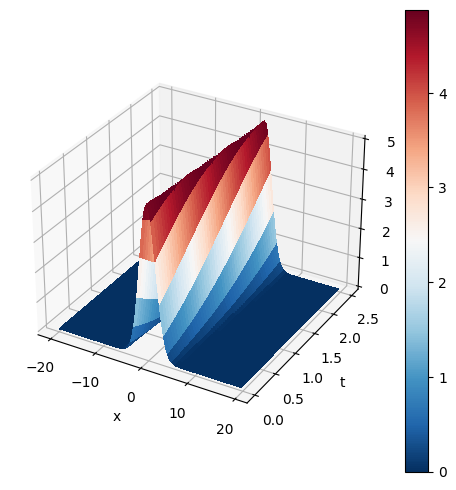

In [20]:
# Plot
fig = plt.figure(figsize = (6,6))

ax = plt.axes(projection='3d')

z = ax.plot_surface(x_grid, t_grid, inv_rho_solution.real, cmap='RdBu_r', linewidth=0, antialiased=False)

# Customised labels for axes
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel(r'$\rho$')

plt.colorbar(z)

plt.show()

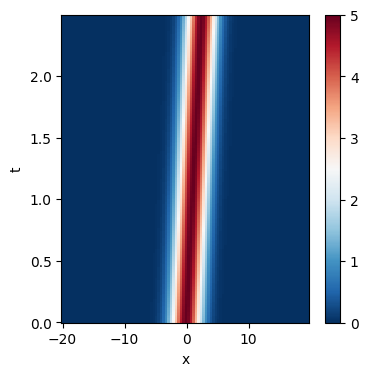

In [21]:
# Projected onto the plane
plt.figure(figsize= (4, 4))

z = plt.pcolor(x_grid, t_grid, inv_rho_solution.real, cmap='RdBu_r')

plt.colorbar(z)

plt.xlabel('x')
plt.ylabel('t')
#plt.zlabel('T')

plt.show()

### Animation:

Now mount our GDrive, so that we can store snapshots and make an animation:

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# To display the contents
#!ls "/content/drive/My Drive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save snapshots:

In [23]:
# Looping over time -> m

for j in range(m):

    plt.figure(figsize= (5, 5))

    plt.plot(x, inv_rho_solution[j, :], color = "magenta")

    plt.xlabel("position [m]")
    plt.ylabel("density")

    plt.savefig("/content/drive/MyDrive/Colab Notebooks/EPIC_4/wave1D{:03d}.png".format(j))

    plt.close()

In [24]:
import glob
from PIL import Image
from IPython import display # To see the animation in our nb

In [25]:
images_in = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/wave****.png"

gif_image_out = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/animation_wave.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))

img = next(imgs)

img.save(fp = gif_image_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

In [26]:
# Display our plane wave solution in our python notebook

#display.Image(open("/content/drive/MyDrive/Colab Notebooks/EPIC_4/animation_wave.gif", "rb").read())

## Section B: 2D advection

In [27]:
# Domain setup
nx = ny = 128        # Number of grid points
lx = ly = 10.0       # Domain size
dx = dy = lx / nx    # Grid spacing
v_x, v_y = 2.5, 0.  # Velocities in x and y directions

# Time discretisation
dt = 0.01
nt = 100                   # Number of time steps

In [28]:
# Initialize grid
x = y = np.linspace(-lx, lx, nx, endpoint=False)

# Meshgrid
x_2d, y_2d = np.meshgrid(x, y, indexing='ij')

# Initial condition:
u0 = rho_0 = 5*np.exp(-x_2d**2/6)

In [29]:
# Apply FFT method for 2D advection
def fft_advection(u0, vx, vy, dt, nt):

    # Go to Fourier frequency domain
    u_hat = np.fft.fft2(u0)
    kx = ky = 2 * np.pi * np.fft.fftfreq(nx, d=dx)
    kx_2d, ky_2d = np.meshgrid(kx, ky, indexing='ij')

    # Advection in Fourier domain
    for n in range(1, nt+1):

        # Compute advection term
        u_hat = u_hat * np.exp(-1j * (vx * kx_2d + vy * ky_2d) * dt)

    # Transform back to spatial domain
    rhs_ode = np.fft.ifft2(u_hat).real

    return rhs_ode

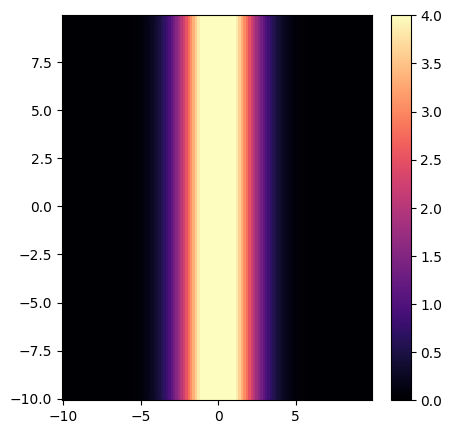

In [30]:
# Plot the initial and final states
plt.figure(figsize=(5, 5))

z1 = plt.pcolor(x_2d, y_2d, u0, cmap='magma', vmin = 0.0, vmax= +4.0)
plt.colorbar(z1)

plt.show()

In [31]:
# Compute the final state
u_final = fft_advection(u0, v_x, v_y, dt, nt)

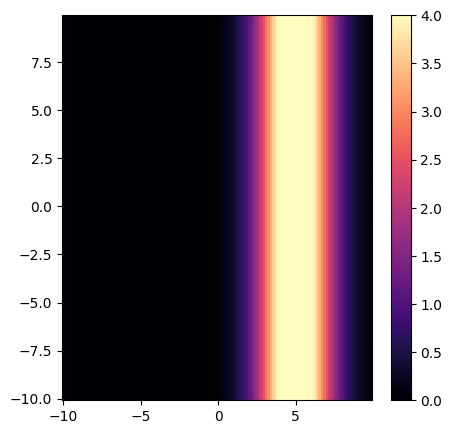

In [32]:
plt.figure(figsize=(5, 5))

z2 = plt.pcolor(x_2d, y_2d, u_final, cmap='magma',  vmin = 0.0, vmax= +4.0)

plt.colorbar(z2)

plt.show()

## Surface plots:

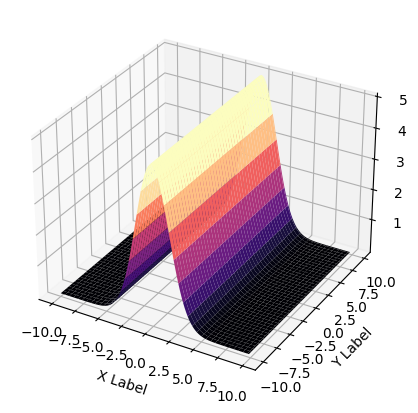

In [33]:
# Plotting

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_2d, y_2d, u0, cmap='magma',  vmin = 0.0, vmax= +4.0)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

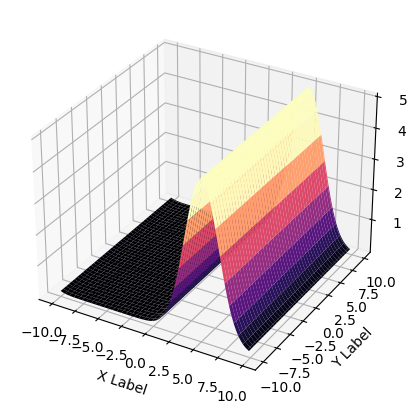

In [34]:
# Plotting

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_2d, y_2d, u_final, cmap='magma',  vmin = 0.0, vmax= +4.0)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [35]:
# Looping over time -> nt

for j in range(1, nt+1):

    # Compute the final state
    u_final = fft_advection(u0, v_x, v_y, dt, j)

    plt.figure(figsize=(5, 5))

    z2 = plt.pcolor(x_2d, y_2d, u_final, cmap='magma',  vmin = 0.0, vmax= +4.0)

    plt.colorbar(z2)

    plt.savefig("/content/drive/MyDrive/Colab Notebooks/EPIC_4/wave2D{:03d}.png".format(j))

    plt.close()


    # Plotting

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x_2d, y_2d, u_final, cmap='magma',  vmin = 0.0, vmax= +4.0)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.savefig("/content/drive/MyDrive/Colab Notebooks/EPIC_4/surf_wave2D{:03d}.png".format(j))

    plt.close()

In [36]:
images_in = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/wave2D**.png"

gif_image_out = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/animation_wave2d.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))

img = next(imgs)

img.save(fp = gif_image_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

In [37]:
images_in = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/surf_wave2D**.png"

gif_image_out = "/content/drive/MyDrive/Colab Notebooks/EPIC_4/surf_animation_wave2d.gif"

imgs = (Image.open(f) for f in sorted(glob.glob(images_in)))

img = next(imgs)

img.save(fp = gif_image_out, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)

In [38]:
# Display our plane wave solution in our python notebook

#display.Image(open("/content/drive/MyDrive/Colab Notebooks/EPIC_4/animation_wave2d.gif", "rb").read())

In [39]:
# Display our plane wave solution in our python notebook

#display.Image(open("/content/drive/MyDrive/Colab Notebooks/EPIC_4/surf_animation_wave2d.gif", "rb").read())

### Group Homework: 1D Shock wave propagation

We wish to study the emergence of 1D shock waves in fluids. To do this we will modify our one-way wave equation to account for non-linear convection, i.e. we will consider that the speed of an initial Gaussian density perturbation $\rho(x, 0) = 4\,e^{-x^2}$ propagating across a periodic 1D domain is not constant, but a function of the density itself, so that our PDE becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =0$$


As we see from the above equation, portions of $\rho$ with larger amplitudes will convect more rapidly, giving rise to wave steepening (i.e. to a discontinuity, which we call a **shock wave**). Without a diffusive term, the shock would become infinitely steep. Therefore, we add a diffusive (parabolic) term to our PDE so that the shock maintains a finite width. Our PDE then becomes:

$$\frac{\partial \rho}{\partial t} + \rho\frac{\partial \rho}{\partial x} =\alpha\frac{\partial^2 \rho}{\partial x^2}$$

where $\alpha$ is a diffusion constant.


**Step 1** Create an appropriate domain and a reasonable time vector for the problem, and make a plot of the initial density profile.


**Step 2** Find the solution, $\rho(x,t)$, **using the FFT method.** Hint: write a python function for the right-hand-side (RHS) of the PDE that allows you to map in and out of the Fourier domain at each time. Note that this PDE is non-linear, so the function should return the RHS in real space.


**Step 3** Feed a scipy ODE integrator with the function you created in the previous step. Hint: choose a reasonable value for the diffusion constant, $\alpha$, and make sure you feed the correct wavenumbers to the ODE integrator.


**Step 4**  Repeat the above calculations for two additional $\alpha$ values (one of them should be 0). Then, make a movie with three panels comparing the results for different $\alpha$ values and briefly discuss the role of this parameter in regulating the morphology of the shock wave.

**Step 5** Challenge: Try this in 2D!